# Chap 08

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

### 8.1

,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


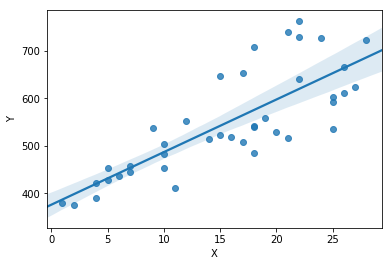

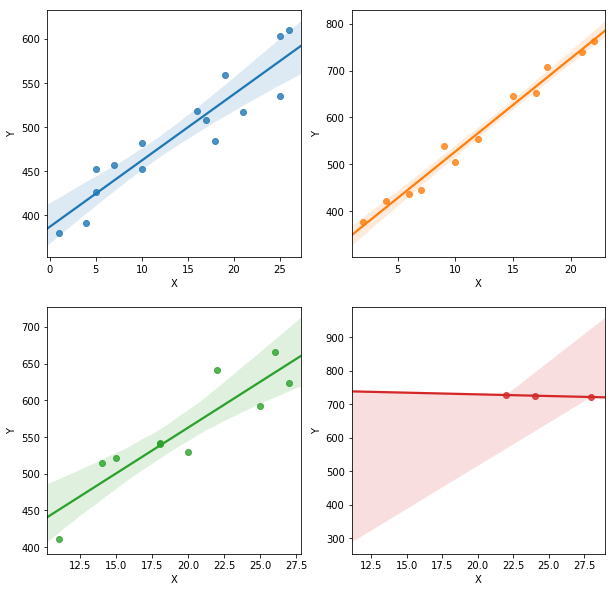

In [3]:
df = pd.read_csv('./input/data-salary-2.txt')
display(df.head())
sns.regplot(x='X', y='Y', data=df, fit_reg=True)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.regplot(x='X', y='Y', data=df[df['KID'] == 1], fit_reg=True, ax=ax[0, 0])
sns.regplot(x='X', y='Y', data=df[df['KID'] == 2], fit_reg=True, ax=ax[0, 1])
sns.regplot(x='X', y='Y', data=df[df['KID'] == 3], fit_reg=True, ax=ax[1, 0])
sns.regplot(x='X', y='Y', data=df[df['KID'] == 4], fit_reg=True, ax=ax[1, 1])

In [49]:
model_81 = pystan.StanModel('./model/model8-1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6db61a6a0511ee8be2ef205bb35cd7bc NOW.


In [50]:
stan_data = {
    'X': df['X'].values,
    'Y': df['Y'].values,
    'N': df.shape[0],
}
fit_81 = model_81.sampling(data=stan_data, seed=1234)
fit_81

Inference for Stan model: anon_model_6db61a6a0511ee8be2ef205bb35cd7bc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a    375.13    0.58  23.89 329.51 359.17 374.86 390.38 421.63   1722    1.0
b     11.12    0.03   1.39   8.34   10.2  11.15  12.03  13.77   1710    1.0
s_Y   68.14     0.2    8.1  54.44  62.59  67.47  73.01  86.61   1691    1.0
lp__ -184.0    0.04   1.33 -187.3 -184.6 -183.7 -183.1 -182.6   1275    1.0

Samples were drawn using NUTS at Mon Oct 30 21:48:01 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

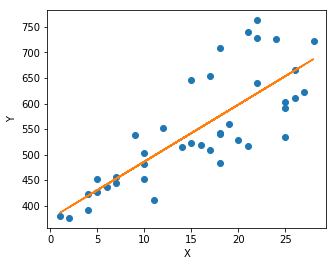

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

a = np.median(fit_81.extract()['a'].T)
b = np.median(fit_81.extract()['b'].T)
s_Y = np.median(fit_81.extract()['s_Y'].T)
X = df['X'].values
y_new = a + b * X
ax.plot(df['X'].values, df['Y'].values, 'o', )
ax.plot(X, y_new)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

In [4]:
model_82 = pystan.StanModel('model/model8-2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1727f5e425ec9203a30d4c44ae2908e NOW.


In [5]:
stan_data = {
    'X': df['X'].values,
    'Y': df['Y'].values,
    'N': df.shape[0],
    'K': df['KID'].nunique(),
    'KID': df['KID'].values,
}
fit_82 = model_82.sampling(data=stan_data, seed=1234)
fit_82

Inference for Stan model: anon_model_c1727f5e425ec9203a30d4c44ae2908e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[0] 386.65    0.27  14.46 357.42 377.06 386.87 396.35 414.73   2943    1.0
a[1] 329.48     0.4  17.15 296.24 318.37 329.15 340.57 364.01   1878    1.0
a[2] 314.67    0.69  34.17 248.32 291.45 314.23 337.44 383.26   2486    1.0
a[3] 747.57    3.19 164.79 420.39 639.68  749.5 855.34 1077.1   2667    1.0
b[0]   7.53    0.02    0.9   5.75   6.93   7.52   8.14   9.29   2938    1.0
b[1]   19.8    0.03   1.26  17.19  18.97  19.82  20.61  22.27   2340    1.0
b[2]  12.42    0.03   1.69   8.94   11.3  12.47  13.56  15.75   2475    1.0
b[3]   -0.9    0.13   6.64 -14.09  -5.24  -1.01   3.51  12.29   2644    1.0
s_Y   27.36    0.07    3.7   21.3  24.75  26.94  29.54  36.01   2903    1.0
lp__ -148.2    0.07   2.44 -153.8 -149.6 -147.8 -14

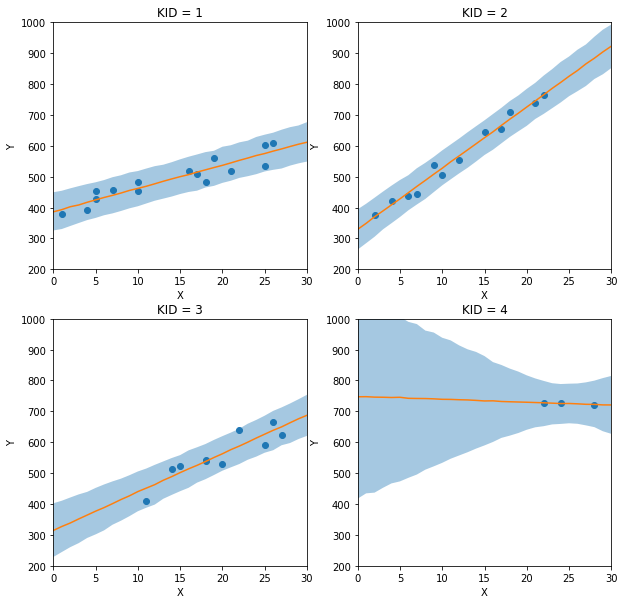

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    a = fit_82.extract()['a'].T[i]
    b = fit_82.extract()['b'].T[i]
    sigma = fit_82.extract()['s_Y']
    X = np.linspace(0, 30, 31)
    y_mu = a.reshape(-1, 1) + b.reshape(-1, 1).dot(X.reshape(1, -1))
    y_new = np.random.normal(y_mu, sigma.reshape(-1, 1))
    y_new_mu = np.percentile(y_new, 50.0, axis=0)
    y_new_u = np.percentile(y_new, 97.5, axis=0)
    y_new_l = np.percentile(y_new, 2.5, axis=0)
    
    X_k = df[df['KID'] == i+1]['X'].values
    Y_k = df[df['KID'] == i+1]['Y'].values

    ax[i // 2, i % 2].plot(X_k, Y_k, 'o', )
    ax[i // 2, i % 2].fill_between(X, y_new_l, y_new_u, alpha=0.4)
    ax[i // 2, i % 2].plot(X, y_new_mu)
    ax[i // 2, i % 2].set_xlabel('X')
    ax[i // 2, i % 2].set_ylabel('Y')
    ax[i // 2, i % 2].set_xlim([0, 30])
    ax[i // 2, i % 2].set_ylim([200, 1000])
    ax[i // 2, i % 2].set_title('KID = %d' % (i+1))

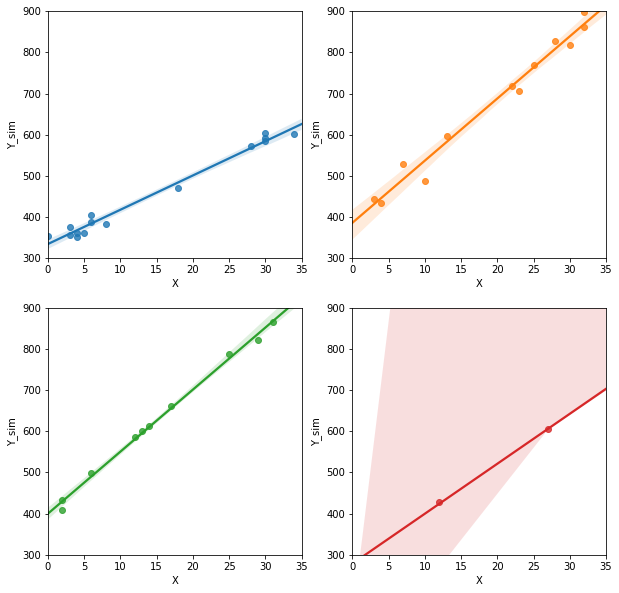

In [12]:
# np.random.seed(1234)
N = 40
K = 4
N_k = [15, 12, 10, 3]
a0 = 350
b0 = 12
s_a = 60
s_b = 4, 
s_Y = 25
X = np.random.randint(35, size=N)
KID = []
for n, i in zip(N_k, range(0, 4)):
    KID.extend([i] * n)

a = np.random.normal(scale=s_a, size=K) + a0
b = np.random.normal(scale=s_b, size=K) + b0
d = pd.DataFrame(dict(X=X, KID=KID, a=a[KID], b=b[KID]))
d['Y_sim'] = np.random.normal(loc=d['a'] + d['b'] * d['X'], scale=s_Y, size=N)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].set_xlim(0, 35)
ax[0, 1].set_xlim(0, 35)
ax[1, 0].set_xlim(0, 35)
ax[1, 1].set_xlim(0, 35)
ax[0, 0].set_ylim(300, 900)
ax[0, 1].set_ylim(300, 900)
ax[1, 0].set_ylim(300, 900)
ax[1, 1].set_ylim(300, 900)
sns.regplot(x='X', y='Y_sim', data=d[d['KID'] == 0], fit_reg=True, ax=ax[0, 0])
sns.regplot(x='X', y='Y_sim', data=d[d['KID'] == 1], fit_reg=True, ax=ax[0, 1])
sns.regplot(x='X', y='Y_sim', data=d[d['KID'] == 2], fit_reg=True, ax=ax[1, 0])
sns.regplot(x='X', y='Y_sim', data=d[d['KID'] == 3], fit_reg=True, ax=ax[1, 1])

In [99]:
model = pystan.StanModel('./model/model8-3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e36ce9cb09fd203b4489d9c77bc1c4d NOW.


In [100]:
stan_data = {
    'X': df['X'].values,
    'Y': df['Y'].values,
    'N': df.shape[0],
    'K': df['KID'].nunique(),
    'KID': df['KID'].values,
}
fit = model.sampling(data=stan_data, seed=1234)
fit

Inference for Stan model: anon_model_4e36ce9cb09fd203b4489d9c77bc1c4d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0    383.25    5.79 121.52 187.42 339.88  367.6 409.51 642.83    441    1.0
b0     12.44    0.44   9.12  -4.39   9.28  12.45  15.46  28.69    422   1.02
ak[0]  -0.33    5.69 120.79 -258.6 -26.45  11.29   42.3 196.58    450    1.0
ak[1] -48.04    5.88 122.98 -319.9 -77.99 -29.11  -0.93 138.42    438    1.0
ak[2] -56.72    5.95 124.88 -328.5 -91.01 -37.11  -2.42 132.74    440    1.0
ak[3]  94.29    6.92 151.55 -88.25   5.82  56.88 148.57 461.82    479    1.0
bk[0]  -4.68    0.44   9.11 -21.13  -7.72  -4.64  -1.49  11.41    429   1.02
bk[1]   6.93    0.45   9.17  -8.79   3.69   6.71  10.14  23.95    424   1.02
bk[2]  -0.58    0.45   9.21 -16.62   -3.8  -0.71    2.6  16.37    423   1.02
bk[3]   -2.5    0.46   9.94 -21.65  -5.91

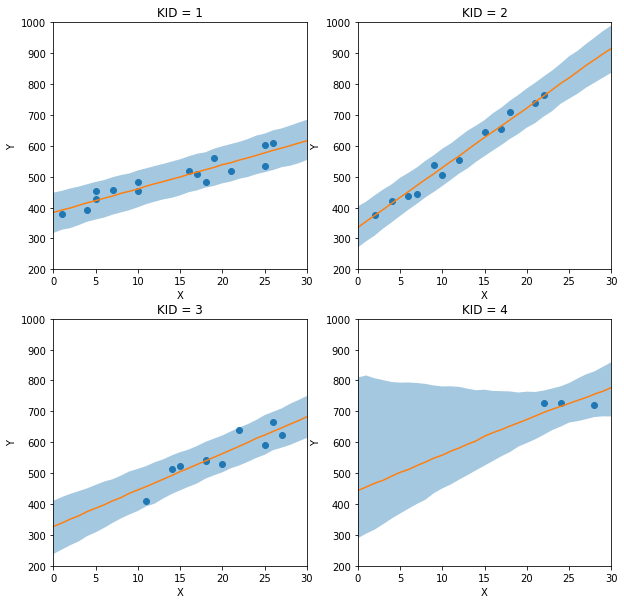

In [101]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    a = fit.extract()['a'].T[i]
    b = fit.extract()['b'].T[i]
    sigma = fit.extract()['s_Y']
    X = np.linspace(0, 30, 31)
    y_mu = a.reshape(-1, 1) + b.reshape(-1, 1).dot(X.reshape(1, -1))
    y_new = np.random.normal(y_mu, sigma.reshape(-1, 1))
    y_new_mu = np.percentile(y_new, 50.0, axis=0)
    y_new_u = np.percentile(y_new, 97.5, axis=0)
    y_new_l = np.percentile(y_new, 2.5, axis=0)
    
    X_k = df[df['KID'] == i+1]['X'].values
    Y_k = df[df['KID'] == i+1]['Y'].values

    ax[i // 2, i % 2].plot(X_k, Y_k, 'o', )
    ax[i // 2, i % 2].fill_between(X, y_new_l, y_new_u, alpha=0.4)
    ax[i // 2, i % 2].plot(X, y_new_mu)
    ax[i // 2, i % 2].set_xlabel('X')
    ax[i // 2, i % 2].set_ylabel('Y')
    ax[i // 2, i % 2].set_xlim([0, 30])
    ax[i // 2, i % 2].set_ylim([200, 1000])
    ax[i // 2, i % 2].set_title('KID = %d' % (i+1))

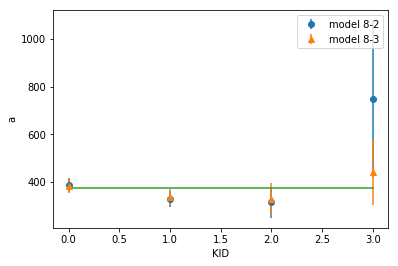

In [74]:
KID = list(range(0, K))
a = fit_82.extract()['a'].T
err_u = np.median(a, axis=1) - np.percentile(a, 2.5, axis=1)
err_d = np.percentile(a, 97.5, axis=1) - np.median(a, axis=1)
err = np.vstack([err_u, err_u])
plt.errorbar(KID, np.median(a, axis=1), yerr=err, fmt="o", label="model 8-2")

a = fit.extract()['a'].T
err_u = np.median(a, axis=1) - np.percentile(a, 2.5, axis=1)
err_d = np.percentile(a, 97.5, axis=1) - np.median(a, axis=1)
err = np.vstack([err_u, err_u])
plt.errorbar(KID, np.median(a, axis=1), yerr=err, fmt='^', label="model 8-3")
X = np.linspace(0, 35, 36)
plt.plot([0, 3], [np.median(fit_81.extract()['a'].T), np.median(fit_81.extract()['a'].T)])
plt.xlabel('KID')
plt.ylabel('a')
plt.legend()

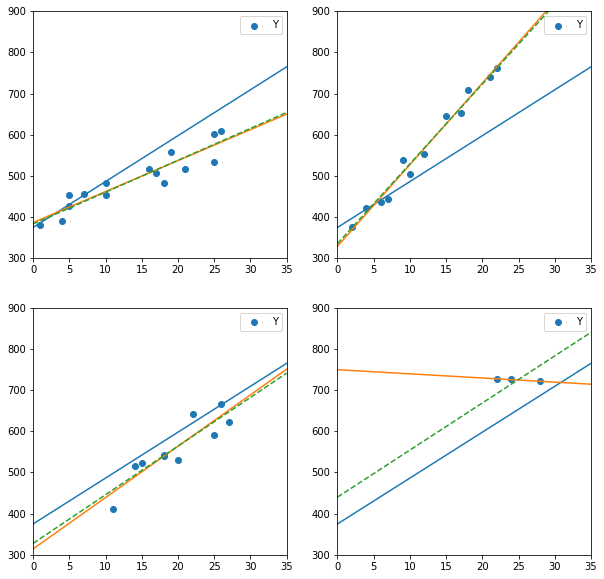

In [83]:
X = np.linspace(0, 35, 36)
mu_81 = np.median(fit_81.extract()['a'].T) + np.median(fit_81.extract()['b'].T) * X

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, ax_ in enumerate(ax.reshape(-1)):
    ax_.set_xlim(0, 35)
    ax_.set_ylim(300, 900)
    ax_.scatter(df[df['KID'] == i+1]['X'], df[df['KID'] == i+1]['Y'])
    mu_82 = np.median(fit_82.extract()['a'].T[i]) + np.median(fit_82.extract()['b'].T[i]) * X
    mu_83 = np.median(fit.extract()['a'].T[i]) + np.median(fit.extract()['b'].T[i]) * X
    ax_.plot(X, mu_81)
    ax_.plot(X, mu_82, '-')
    ax_.plot(X, mu_83, '--')
    ax_.legend()

### 8.2

,X,Y,KID,GID
0,7,457,1,1
1,10,482,1,1
2,16,518,1,1
3,25,535,1,1
4,5,427,1,1


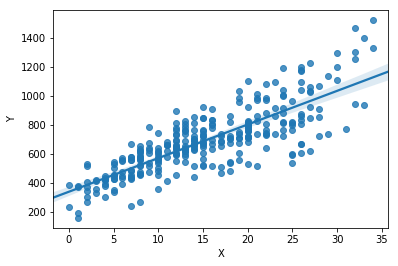

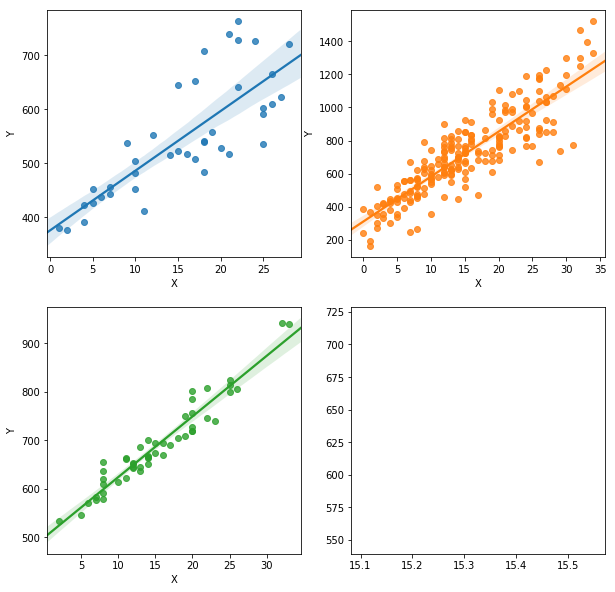

In [102]:
df = pd.read_csv('./input/data-salary-3.txt')
display(df.head())
sns.regplot(x='X', y='Y', data=df, fit_reg=True)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.regplot(x='X', y='Y', data=df[df['GID'] == 1], fit_reg=True, ax=ax[0, 0])
sns.regplot(x='X', y='Y', data=df[df['GID'] == 2], fit_reg=True, ax=ax[0, 1])
sns.regplot(x='X', y='Y', data=df[df['GID'] == 3], fit_reg=True, ax=ax[1, 0])

/Users/tomohiro/Workspace/RStanBook-Python/.env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


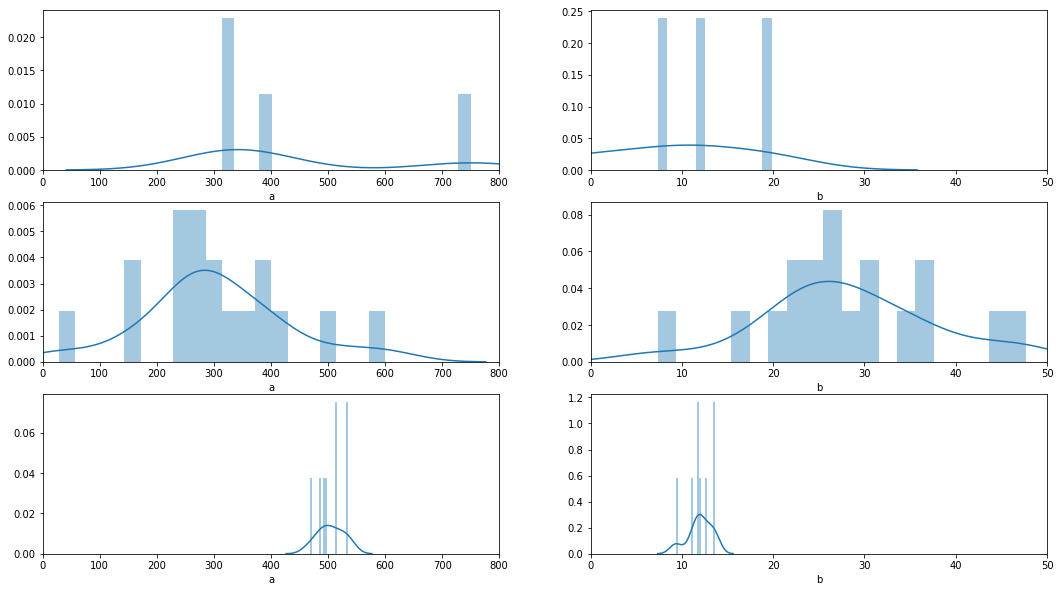

In [103]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table


df = sm.add_constant(df)

fitted = []
for k in df['KID'].unique():
    model = sm.OLS(df[df['KID'] == k]['Y'], df[df['KID'] == k][['const', 'X']])
    fitted.append(model.fit())

result_df = df[['KID', 'GID']].drop_duplicates()
result_df['a'] = [fitted[i].params[0] for i in range(len(fitted))]
result_df['b'] = [fitted[i].params[1] for i in range(len(fitted))]

fig, ax = plt.subplots(3, 2, figsize=(18, 10))
sns.distplot(result_df[result_df['GID'] == 1]['a'], ax=ax[0, 0], bins=20)
sns.distplot(result_df[result_df['GID'] == 2]['a'], ax=ax[1, 0], bins=20)
sns.distplot(result_df[result_df['GID'] == 3]['a'], ax=ax[2, 0], bins=20)
for ax_ in ax[:, 0].reshape(-1):
    ax_.set_xlim([0, 800])
sns.distplot(result_df[result_df['GID'] == 1]['b'], ax=ax[0, 1], bins=20)
sns.distplot(result_df[result_df['GID'] == 2]['b'], ax=ax[1, 1], bins=20)
sns.distplot(result_df[result_df['GID'] == 3]['b'], ax=ax[2, 1], bins=20)
for ax_ in ax[:, 1].reshape(-1):
    ax_.set_xlim([0, 50])

In [104]:
model_85 = pystan.StanModel('./model/model8-5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5c12891c1771ce166d5916fdf264e41 NOW.


In [105]:
df = pd.read_csv('./input/data-salary-3.txt')
N = df.shape[0]
G = df['GID'].nunique()
K = df['KID'].nunique()
X = df['X'].values
Y = df['Y'].values
KID = df['KID'].values
K2G = df[['KID', 'GID']].drop_duplicates()['GID'].values

stan_data = {
    'N': N,
    'G': G,
    'K': K, 
    'X': X,
    'Y': Y,
    'KID': KID,
    'K2G': K2G
}
fit_85 = model_85.sampling(stan_data, seed=1234)
fit_85

Inference for Stan model: anon_model_c5c12891c1771ce166d5916fdf264e41.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0    389.84   17.82 453.56 -297.3 303.37 383.48 462.77 1132.1    648   1.01
b0     86.43    72.8 530.01 -102.2  10.55  18.55  26.08  305.8     53   1.08
a1[0] 359.21    1.11  29.89 298.71 339.36 358.83 378.92 418.75    724    1.0
a1[1] 299.25    0.55  13.74 272.36 290.03  299.2 307.92 326.94    614    1.0
a1[2] 501.11    1.34  29.92 441.77 480.92 501.98 521.44 558.33    498   1.01
b1[0]  13.07    0.06   2.75   7.62  11.31  13.01   14.9  18.49   1859    1.0
b1[1]  28.55    0.07   1.48  25.34  27.56  28.57  29.54  31.41    452    1.0
b1[2]  12.39     0.1   2.56    7.3  10.67  12.32   14.1  17.55    664   1.01
a[0]  364.69    1.04  27.51 313.05 345.57 364.89  383.1  417.5    695    1.0
a[1]  357.03    1.03  29.71 294.54 337.07

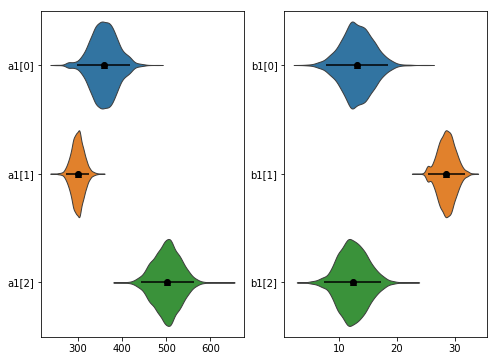

In [113]:
extracted = fit_85.extract()

params = ['a1', 'b1']
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
for i, p in enumerate(params):
    result_df = pd.DataFrame({
        '%s[0]' % p: extracted['%s' % p][:, 0],
        '%s[1]' % p: extracted['%s' % p][:, 1],
        '%s[2]' % p: extracted['%s' % p][:, 2],
    })

    sns.violinplot(data=result_df, orient="h", scale='count', linewidth=1, inner=None, ax=ax[i])
    err_u = result_df.median() - result_df.describe([0.025, 0.975]).loc['2.5%']
    err_d = result_df.describe([0.025, 0.975]).loc['97.5%'] - result_df.median()
    err = np.vstack([err_u.values, err_u.values])
    ax[i].errorbar(result_df.median(), result_df.columns, xerr=err, fmt='^', color='k')
    ax[i].scatter(result_df.median(), result_df.columns, color='k')

In [231]:
model_86 = pystan.StanModel('./model/model8-6.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7fbc7a3189cfa9efb3455bf59e2e175f NOW.


In [232]:
df = pd.read_csv('./input/data-salary-3.txt')
N = df.shape[0]
G = df['GID'].nunique()
K = df['KID'].nunique()
X = df['X'].values
Y = df['Y'].values
KID = df['KID'].values
GID = df['GID'].values
K2G = df[['KID', 'GID']].drop_duplicates()['GID'].values

stan_data = {
    'N': N,
    'G': G,
    'K': K, 
    'X': X,
    'Y': Y,
    'KID': KID,
    'GID': GID,
    'K2G': K2G
}
fit_86 = model_86.sampling(stan_data, seed=1234)
fit_86

Inference for Stan model: anon_model_7fbc7a3189cfa9efb3455bf59e2e175f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0     372.82   30.32 641.04 -827.0 294.28 393.22 485.73 1216.8    447   1.01
b0      28.24   10.19 112.14  -54.9   10.4  19.02  26.93 120.36    121   1.03
a1[0]  381.17    2.62  79.51 241.29 342.89 370.08 415.11 557.84    919   1.01
a1[1]   299.3    0.49  16.69 266.13 288.58  299.5 309.84 333.87   1165    1.0
a1[2]  500.62    0.45  10.06 480.54 494.06 500.95 507.18 519.87    499   1.02
b1[0]   13.56    0.48   6.69   1.33   10.4  13.16  16.26   27.8    197   1.02
b1[1]   28.53    0.04   1.65  25.36  27.47  28.49  29.59  31.83   1525    1.0
b1[2]   12.35    0.03   0.59  10.99  12.02  12.41  12.74  13.35    499   1.01
a[0]   383.98    0.79  15.09 353.44 373.95 384.16 394.14 411.73    369   1.01
a[1]    334.1     1.3  19.06 29

### 8.3

,PersonID,Time1,Time2,Time4,Time8,Time12,Time24
0,1,2.4,5.0,7.5,11.9,12.5,12.7
1,2,1.4,3.9,4.4,7.7,6.4,8.3
2,3,5.2,9.4,19.4,20.2,22.7,24.9
3,4,6.7,12.6,19.1,23.4,25.8,26.1
4,5,0.3,4.7,7.0,10.2,12.9,14.8


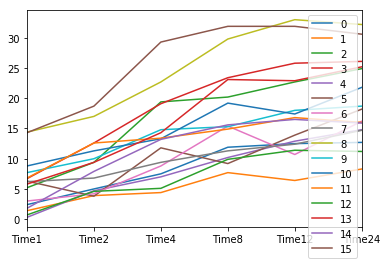

In [307]:
df = pd.read_csv('./input/data-conc-2.txt')
display(df.head())
df.iloc[:, 1:].T.plot()

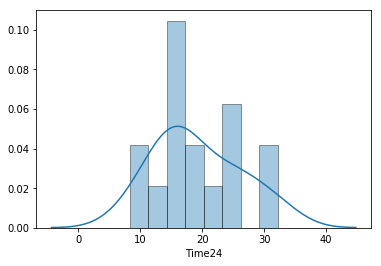

In [271]:
sns.distplot(df['Time24'], bins=8, hist_kws=dict(edgecolor="k", linewidth=1))

In [272]:
model_87 = pystan.StanModel('./model/model8-7.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c679b3cbe2c58b73ccc8a662c4d1b9d NOW.


In [276]:
stan_data = {
    'N': df.shape[0],
    'Y': df.iloc[:, 1:].values,
    'T': 6,
    'Time': np.array([1, 2, 4, 8, 12, 24]),
    'T_new': 60,
    'Time_new': np.linspace(0, 24, 60),
}
fit_87 = model_87.sampling(stan_data, seed=1234)
fit_87

Inference for Stan model: anon_model_2c679b3cbe2c58b73ccc8a662c4d1b9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0             2.86  1.7e-3   0.11   2.64   2.79   2.86   2.93   3.08   4000    1.0
b0            -1.18  2.2e-3   0.12  -1.43  -1.26  -1.17  -1.09  -0.94   3031    1.0
log_a[0]       2.56  1.5e-3   0.09   2.37   2.49   2.56   2.62   2.74   4000    1.0
log_a[1]       2.11  2.3e-3   0.15   1.83   2.01   2.11    2.2   2.41   4000    1.0
log_a[2]       3.17  7.9e-4   0.05   3.07   3.14   3.17    3.2   3.27   4000    1.0
log_a[3]       3.25  7.3e-4   0.05   3.16   3.22   3.25   3.29   3.34   4000    1.0
log_a[4]       2.64  1.7e-3   0.11   2.42   2.56   2.64   2.71   2.85   4000    1.0
log_a[5]       2.75  1.6e-3    0.1   2.56   2.68   2.74   2.81   2.95   4000    1.0
log_a[6]       2.69  1.4e-3   0.09   2.52   2.63   2.69

In [335]:
y_new[:, i, :].shape

(4000, 60)

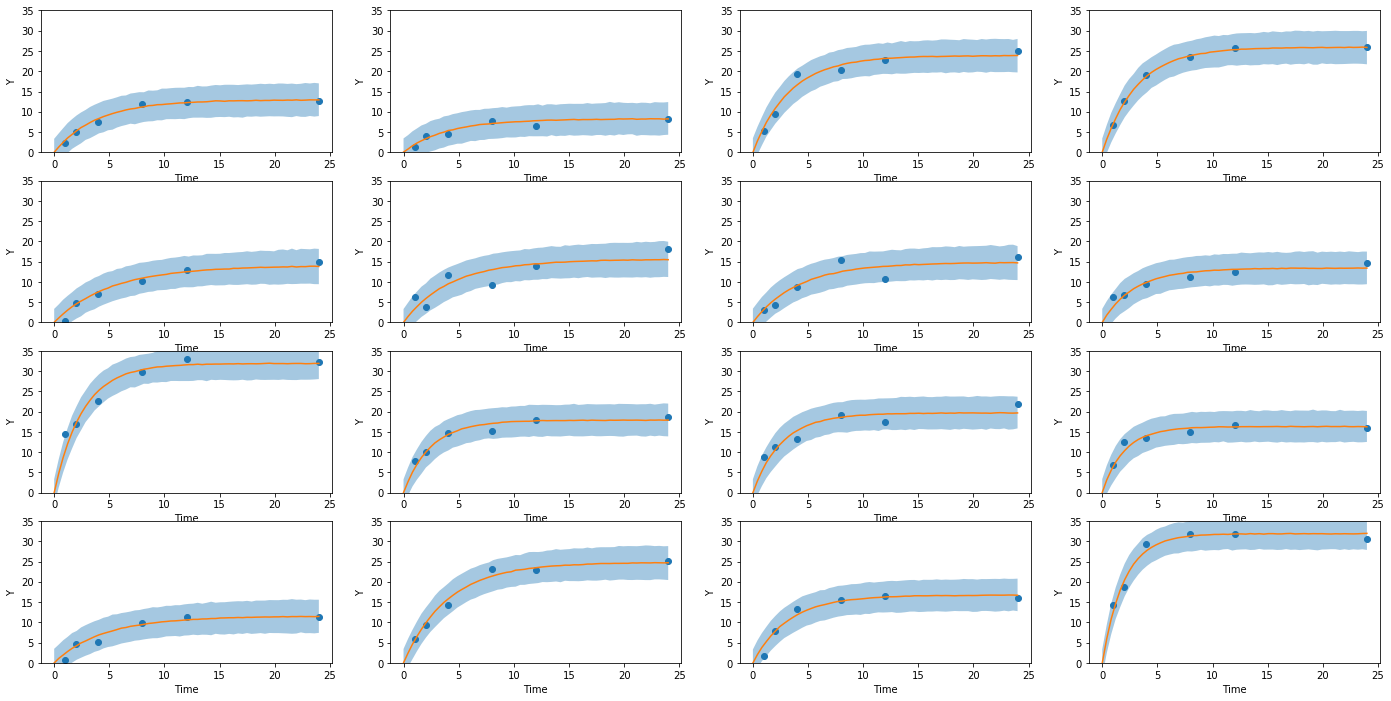

In [337]:
fig, ax = plt.subplots(4, 4, figsize=(24, 12))

y_new = fit_87.extract()['y_new']
times = [1, 2, 4, 8, 12, 24]
time_new = np.linspace(0, 24, 60)
for i, ax_ in enumerate(ax.reshape(-1)):
    ax_.plot(times, df.iloc[i, 1:].values, 'o', )
    mu = np.median(y_new[:, i, :], axis=0)
    ax_.plot(time_new, mu)
    ax_.fill_between(time_new, np.percentile(y_new[:, i, :], 2.5, axis=0), np.percentile(y_new[:, i, :], 97.5, axis=0), alpha=0.4)
    ax_.set_ylim([0, 35])
    ax_.set_xlabel('Time')
    ax_.set_ylabel('Y')

### 8.4

In [114]:
df1 = pd.read_csv('input/data-attendance-4-1.txt')
df2 = pd.read_csv('input/data-attendance-4-2.txt')
display(df1.head())
display(df2.head())

,PersonID,A,Score
0,1,0,69
1,2,1,145
2,3,0,125
3,4,1,86
4,5,1,158


,PersonID,CourseID,Weather,Y
0,1,3,B,1
1,1,9,A,1
2,1,1,C,1
3,1,9,A,1
4,1,7,B,1


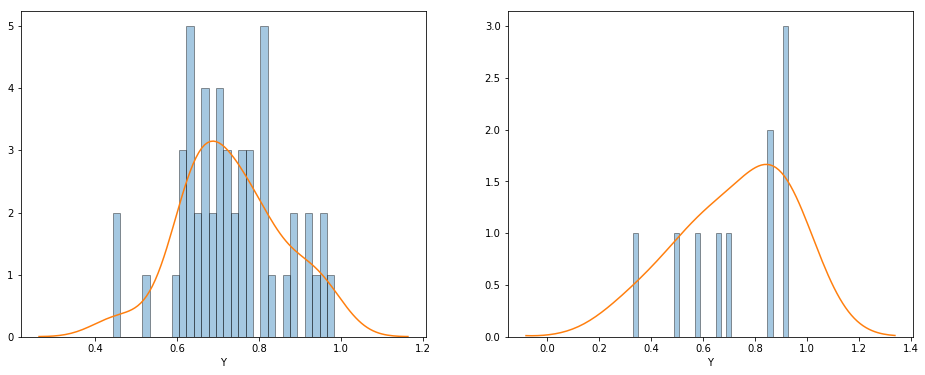

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.distplot(df2.groupby('PersonID')['Y'].mean(), hist_kws=dict(edgecolor='k'), bins=30, ax=ax[0], kde=False)
sns.distplot(df2.groupby('PersonID')['Y'].mean(), hist=False, bins=30, ax=ax[0], kde=True)
sns.distplot(df2.groupby('CourseID')['Y'].mean(), hist_kws=dict(edgecolor='k'), bins=30, ax=ax[1], kde=False)
sns.distplot(df2.groupby('CourseID')['Y'].mean(), hist=False, bins=30, ax=ax[1], kde=True)

In [189]:
model_88 = pystan.StanModel('./model/model8-8.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05935f457d7b722a971dda9c9eda8ab9 NOW.


In [190]:
N = df1.shape[0]
C = df2['CourseID'].nunique()
I = df2.shape[0]
w_map = dict(A=0.0, B=0.2, C=1.0)
df2['W'] = df2['Weather'].apply(lambda x: w_map[x])
stan_data = {
    'N': N,
    'C': C,
    'I': I,
    'A': df1['A'].values,
    'Score': df1['Score'].values / 200.0,
    'PID': df2['PersonID'].values,
    'CID': df2['CourseID'].values,
    'W': df2['W'].values,
    'Y': df2['Y'].values,
}

fit_88 = model_88.sampling(stan_data, seed=1234, pars=['b', 'b_P', 'b_C', 's_P', 's_C', 'q'])
fit_88

Inference for Stan model: anon_model_05935f457d7b722a971dda9c9eda8ab9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]      0.77    0.02    0.6  -0.41   0.37   0.77   1.14   1.97    826    1.0
b[1]      -0.8  2.8e-3   0.16  -1.09   -0.9   -0.8  -0.69  -0.48   3069    1.0
b[2]      1.72    0.01    0.6   0.58   1.32   1.71   2.11   2.95   2836    1.0
b[3]     -0.78  2.4e-3   0.15  -1.09  -0.88  -0.78  -0.68  -0.48   4000    1.0
b_P[0]    0.27  4.9e-3   0.31  -0.29   0.06   0.25   0.46   0.95   4000    1.0
b_P[1]   -0.35  4.3e-3   0.27  -0.91  -0.53  -0.34  -0.16   0.16   4000    1.0
b_P[2]   -0.27  4.9e-3   0.31  -0.91  -0.47  -0.26  -0.05    0.3   4000    1.0
b_P[3]    0.37  4.6e-3   0.29  -0.15   0.17   0.35   0.55   0.98   4000    1.0
b_P[4]   -0.01  4.4e-3   0.28  -0.58  -0.19-9.6e-3   0.17   0.54   4000    1.0
b_P[5]    0.42  5.3e-

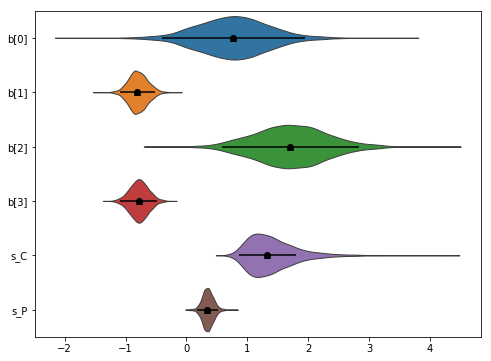

In [191]:
extracted = fit_88.extract()
result_df = pd.DataFrame({
    'b[0]': extracted['b'][:, 0],
    'b[1]': extracted['b'][:, 1],
    'b[2]': extracted['b'][:, 2],
    'b[3]': extracted['b'][:, 3],
    's_P': extracted['s_P'],
    's_C': extracted['s_C'],
})

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=result_df, orient="h", scale='count', linewidth=1, inner=None)
err_u = result_df.median() - result_df.describe([0.025, 0.975]).loc['2.5%']
err_d = result_df.describe([0.025, 0.975]).loc['97.5%'] - result_df.median()
err = np.vstack([err_u.values, err_u.values])
plt.errorbar(result_df.median(), result_df.columns, xerr=err, fmt='^', color='k')
plt.scatter(result_df.median(), result_df.columns, color='k')

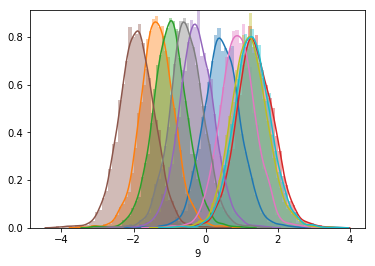

In [192]:
result_df = pd.DataFrame(fit_88.extract()['b_C'])
for col in result_df.columns:
    sns.distplot(result_df[col], )

0.794515986173
0.790676168419 ~ 0.797473436795


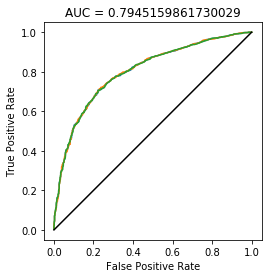

In [241]:
from sklearn.metrics import roc_curve, roc_auc_score

Y = df2['Y'].values
q = fit_88.extract()['q']
auc = np.zeros((q.shape[0], 1))
for i, q_ in enumerate(q):
    auc[i] = roc_auc_score(Y, q_)

    auc_med = np.percentile(auc, 50.0)
auc_l = np.percentile(auc, 10.0)
auc_u = np.percentile(auc, 90.0)
print(auc_med)
print(auc_l, '~', auc_u)

q_med = np.percentile(q, 50.0, axis=0)
q_l = np.percentile(q, 10.0, axis=0)
q_u = np.percentile(q, 90.0, axis=0)
false_positive_rate, true_positive_rate, _ = roc_curve(Y, q_med)
false_positive_rate_l, true_positive_rate_l, _ = roc_curve(Y, q_l)
false_positive_rate_u, true_positive_rate_u, _ = roc_curve(Y, q_u)



fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate)
ax.plot(false_positive_rate_l, true_positive_rate_l)
ax.plot(false_positive_rate_u, true_positive_rate_u)
ax.plot([0, 1], [0, 1], "k-")

ax.set_aspect('equal')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC = {0}".format(auc_med))
plt.show()

In [174]:
model_ex5 = pystan.StanModel('./exercise/ex5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39a669354edcc0a2dd40a0fe987ad624 NOW.


In [175]:
N = df1.shape[0]
C = df2['CourseID'].nunique()
I = df2.shape[0]
w_map = dict(A=0.0, B=0.2, C=1.0)
df2['W'] = df2['Weather'].apply(lambda x: w_map[x])
stan_data = {
    'N': N,
    'C': C,
    'I': I,
    'A': df1['A'].values,
    'Score': df1['Score'].values / 200.0,
    'PID': df2['PersonID'].values,
    'CID': df2['CourseID'].values,
    'W': df2['W'].values,
    'Y': df2['Y'].values,
}

fit_ex5 = model_ex5.sampling(stan_data, seed=1234, pars=['b', 'b_P', 'b_C', 's_P', 's_C', 'q'])
fit_ex5

Inference for Stan model: anon_model_39a669354edcc0a2dd40a0fe987ad624.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]     10.56    9.34  13.21  -4.77  -0.98   3.83  25.93  32.12      2   8.28
b[1]      2.31    6.21   8.78 -13.41  -5.58   6.14   9.12   9.77      2  12.18
b[2]    -13.92   19.03  26.91 -46.36 -40.15 -16.38  10.37   29.0      2  10.62
b[3]     -0.83    0.02   0.15  -1.12  -0.94  -0.84  -0.73  -0.54     82   1.06
b_P[0]   -4.48    4.01   5.67 -13.76  -11.3  -2.84   0.71    2.0      2   6.73
b_P[1]   -3.26    2.34   3.31  -8.14  -6.67  -3.44   0.38   2.14      2   5.11
b_P[2]   -1.76    2.71   3.83  -8.51  -4.33  -1.08   1.41   3.18      2   5.91
b_P[3]   -6.32    7.79  11.01 -20.13 -16.62  -6.94    3.4  11.26      2  14.39
b_P[4]   -1.51    1.12   1.94  -4.87  -3.21  -1.59   0.26   1.68      3   2.47
b_P[5]    2.44    3.1

b[0]    42246.047516
b[1]     9229.298155
b[2]   -55662.553649
b[3]    -3339.376443
dtype: float64

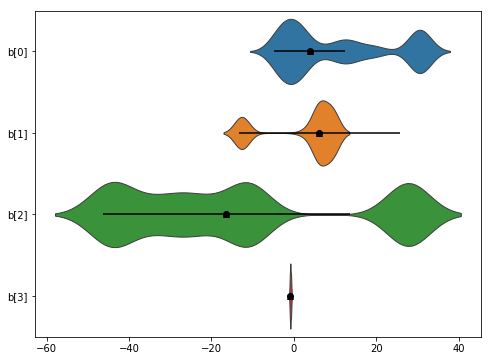

In [182]:
extracted = fit_ex5.extract()
result_df = pd.DataFrame({
    'b[0]': extracted['b'][:, 0],
    'b[1]': extracted['b'][:, 1],
    'b[2]': extracted['b'][:, 2],
    'b[3]': extracted['b'][:, 3],
#     's_P': extracted['s_P'],
#     's_C': extracted['s_C'],
})
display(result_df.sum())
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=result_df, orient="h", scale='count', linewidth=1, inner=None)
err_u = result_df.median() - result_df.describe([0.025, 0.975]).loc['2.5%']
err_d = result_df.describe([0.025, 0.975]).loc['97.5%'] - result_df.median()
err = np.vstack([err_u.values, err_u.values])
plt.errorbar(result_df.median(), result_df.columns, xerr=err, fmt='^', color='k')
plt.scatter(result_df.median(), result_df.columns, color='k')

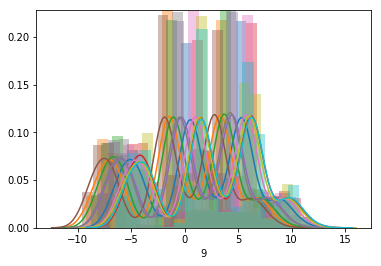

In [183]:
result_df = pd.DataFrame(fit_ex5.extract()['b_C'])
for col in result_df.columns:
    sns.distplot(result_df[col], )

0.796904348336
0.793738303746 ~ 0.799335704463


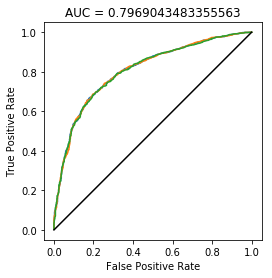

In [242]:
from sklearn.metrics import roc_curve, roc_auc_score

Y = df2['Y'].values
q = fit_ex5.extract()['q']
auc = np.zeros((q.shape[0], 1))
for i, q_ in enumerate(q):
    auc[i] = roc_auc_score(Y, q_)

    auc_med = np.percentile(auc, 50.0)
auc_l = np.percentile(auc, 10.0)
auc_u = np.percentile(auc, 90.0)
print(auc_med)
print(auc_l, '~', auc_u)

q_med = np.percentile(q, 50.0, axis=0)
q_l = np.percentile(q, 10.0, axis=0)
q_u = np.percentile(q, 90.0, axis=0)
false_positive_rate, true_positive_rate, _ = roc_curve(Y, q_med)
false_positive_rate_l, true_positive_rate_l, _ = roc_curve(Y, q_l)
false_positive_rate_u, true_positive_rate_u, _ = roc_curve(Y, q_u)



fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate)
ax.plot(false_positive_rate_l, true_positive_rate_l)
ax.plot(false_positive_rate_u, true_positive_rate_u)
ax.plot([0, 1], [0, 1], "k-")

ax.set_aspect('equal')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC = {0}".format(auc_med))
plt.show()

In [268]:
df = pd.read_csv('./input/data7a.csv')
print(df.shape)
df.head()

(100, 2)


,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


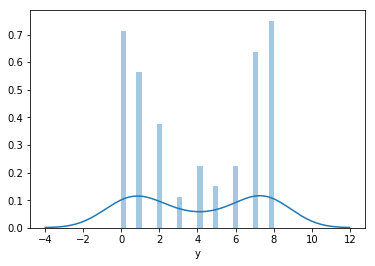

In [270]:
sns.distplot(df['y'], bins=30)

In [246]:
model_ex6 = pystan.StanModel('./exercise/ex6.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8aa7daec1d8e99bb6847650f3e9ce68a NOW.


In [248]:
stan_data = {
    'N':df.shape[0], 
    'Y': df['y'].values
}

fit_ex6 = model_ex6.sampling(stan_data, seed=1234)
fit_ex6

Inference for Stan model: anon_model_8aa7daec1d8e99bb6847650f3e9ce68a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b         0.05    0.01   0.33   -0.6  -0.17   0.05   0.27   0.69    670   1.01
b_I[0]   -3.86    0.03   1.76  -7.94  -4.88   -3.6  -2.65  -1.02   4000    1.0
b_I[1]   -1.22    0.01   0.87  -3.01  -1.77  -1.17  -0.63   0.44   4000    1.0
b_I[2]    2.02    0.02   1.13   0.14   1.23    1.9   2.68   4.56   4000    1.0
b_I[3]    3.84    0.03    1.8   1.01   2.52   3.62   4.84   8.06   4000    1.0
b_I[4]   -2.06    0.02   1.11  -4.62   -2.7  -1.97   -1.3  -0.16   4000    1.0
b_I[5]     2.0    0.02   1.09    0.1   1.23   1.92   2.68   4.33   4000    1.0
b_I[6]    3.76    0.03   1.75   0.98    2.5   3.53   4.72   7.93   4000    1.0
b_I[7]    3.81    0.03   1.78   0.91   2.52   3.59   4.85   7.81   4000    1.0
b_I[8]   -2.07    0.0

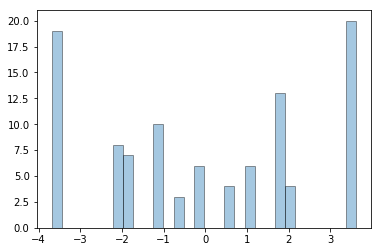

In [266]:
b_I = fit_ex6.extract()['b_I'].T
b_I_med = np.percentile(b_I, 50.0, axis=1)
sns.distplot(b_I_med, bins=30, hist_kws=dict(edgecolor='k'), kde=False)

In [271]:
df = pd.read_csv('./input/d1.csv')
df.head()

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


In [272]:
model_ex7 = pystan.StanModel('./exercise/ex7.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92d498277e84fb5616f766636c23746b NOW.


In [283]:
N = df.shape[0]
N_Pot = df['pot'].nunique()
F = df['f'].apply(lambda f: 0 if f == 'C' else 1).values
pots = list(df['pot'].unique())
N2Pot = df['pot'].apply(lambda p: pots.index(p)+1).values
Y = df['y'].values

stan_data = {
  'N': N, 
  'N_Pot': N_Pot,
  'F': F,
  'N2Pot': N2Pot,
  'Y': Y,
}
fit_ex7 = model_ex7.sampling(stan_data, seed=1234)
fit_ex7

Inference for Stan model: anon_model_92d498277e84fb5616f766636c23746b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]       1.37    0.02   0.51   0.38   1.03   1.37   1.69   2.41    890    1.0
b[1]      -0.84    0.02   0.73  -2.28   -1.3  -0.87  -0.39   0.67    914    1.0
b_I[0]    -0.05  7.6e-3   0.48  -1.04  -0.36  -0.04   0.29   0.84   4000    1.0
b_I[1]    -0.61  8.6e-3   0.54  -1.75  -0.97   -0.6  -0.24    0.4   4000    1.0
b_I[2]     1.08  9.9e-3   0.39   0.32   0.82   1.08   1.35   1.87   1557    1.0
b_I[3]    -0.21  7.6e-3   0.48  -1.18  -0.52   -0.2   0.11   0.71   4000    1.0
b_I[4]    -1.56    0.01   0.71  -3.08  -2.01  -1.52  -1.07  -0.31   4000    1.0
b_I[5]     1.08  9.6e-3   0.38   0.32   0.82   1.09   1.34   1.83   1595    1.0
b_I[6]     -0.4  8.1e-3   0.51  -1.42  -0.74  -0.38  -0.04   0.56   4000    1.0
b_I[7]     

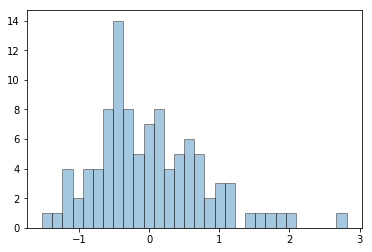

In [284]:
b_I = fit_ex7.extract()['b_I'].T
b_I_med = np.percentile(b_I, 50.0, axis=1)
sns.distplot(b_I_med, bins=30, hist_kws=dict(edgecolor='k'), kde=False)

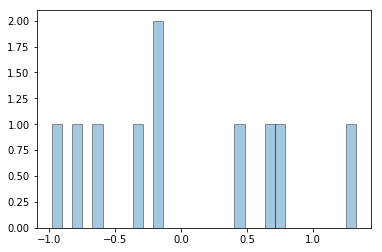

In [286]:
b_Pot = fit_ex7.extract()['b_Pot'].T
b_Pot_med = np.percentile(b_Pot, 50.0, axis=1)
sns.distplot(b_Pot_med, bins=30, hist_kws=dict(edgecolor='k'), kde=False)